In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy.random as random

In [4]:
class game:
    def __init__(self, H, Memb = None, Ls = None, lattice = square_lattice,
                                    max_consecutive_failures = 20):
        '''
        Three possible moves:   1. add new spin
                                2. copy a spin
                                3. add interaction
        
        Input:
         - H: initial hamiltonian that will be translated to architecture 
         - Memb: Number of sites where embedded hamiltonian is defined
         - Ls: tuple with linear sizes if Memb is not a perfect root
         - lattice: function that for site i,j gives a list of neighbours, e.g.
                     [[i+1,j],[i-1,j],[i,j+1],[i+1,j-1]]
                     (default: square lattice with closed boundary conditions)
         
        Methods implemented:
         ....
        '''
        # Copy of the original hamiltonian 
        self.H = np.array(H)
        # Copy of the hamiltonian that will be used for the game
        # self.Hmask = np.array(H)

        # number of spins
        self.nS = H.shape[0]
        
        if Memb is None:
            self.Hemb = H*0.0
            self.Memb = self.nS
        else:
            self.Hemb = np.zeros((Memb, Memb))
            # Copy of the hamiltonian that will be used for the game
            self.Hmask = np.zeros((Memb, Memb))
            self.Hmask[:self.nS,:self.nS] = 1*(np.abs(self.H)>0)
            self.Memb = Memb
        
        # whether it has been used or not        
        self.usedS = np.zeros(self.nS)
        # array of unique spins
        self.uniqS = np.zeros(self.Memb, dtype=int)-1
        # indices of original spin that it might be copy of
        self.origS = np.zeros(self.Memb) 
        
        # Linear sizes
        if Ls is None:
            L = np.int(np.sqrt(self.Memb))
            self.Lx, self.Ly = L, L
        else:
            self.Lx, self,Ly = Ls[0], Ls[1]
        
        # Number of spins and unique spins
        self.N = 0
        self.N0 = 0
        # lattice function
        self.lattice = lattice
        
        # State: turn of copying or adding a new one
        self.copyadd = 1
        self.empty_sites = self.Memb
        self.terms_left = (self.Hmask>0).sum()
        self.finished = 0
        self.score = 0
        self.reward = 0
        self.state = self.get_state()
        self.number_nomoves = 0
        self.max_confailures = max_consecutive_failures 
        
    def get_state(self):
        return np.concatenate((np.expand_dims(self.Hemb,0),
                                     np.expand_dims(self.Hmask,0)))
            
    
    def __len__(self):
        return self.N
    
    
    def add_new_spin(self, i):
        '''
          - i: index of new spin or row in hamiltonian
          
        '''
        if self.uniqS[i]==-1 and self.N0<self.nS:
            self.uniqS[i] = self.N0
            #self.usedS[i] = 1


            # Interacting terms that we use
            h0 = self.H[self.N0, self.N0]*1.0
            self.Hmask[self.N0, self.N0] = 0.0
            
            self.Hemb[i,i] = h0

            self.N += 1
            self.N0 += 1
            self.empty_sites -= 1
            self.terms_left -= 1
            self.update_score(0)
            self.number_nomoves = 0
        else:
            self.number_nomoves += 1
        
            #It's already occupied
    
    def copy_spin(self, i, j, fer_int = 1.0):
        if self.uniqS[i] != self.uniqS[j] and self.uniqS[j] == -1:
            self.uniqS[j] = self.uniqS[i]
            self.Hemb[i,j] = fer_int
            self.Hemb[j,i] = fer_int
            self.Hemb[j,j] = self.Hemb[i,i]*1.0

            self.N += 1
            self.empty_sites -= 1
            self.update_score(1)

            self.number_nomoves = 0
        else:
            self.number_nomoves += 1
            
    def add_interaction(self, i, j, jint = None):
        '''
          - i, j: indices of (neighbouring) sites to connect
        '''
        
        i0 = self.uniqS[i] 
        j0 = self.uniqS[j]
        
        if i0> -1 and j0> -1:
            jint = self.H[i0,j0]
            jint0 = self.Hmask[i0,j0]
            if jint0>0.0:
                #print(jint,i0,j0)
                self.Hemb[i,j] = jint
                self.Hemb[j,i] = jint

                self.Hmask[i0,j0] = 0.0
                self.Hmask[j0,i0] = 0.0

                self.terms_left -= 2
                self.update_score(2)
                self.number_nomoves = 0
        else:
            # At least one of them does not exists
            self.number_nomoves += 1
            
        
        
    def update_score(self, i):
        if i == 0:
            # Added new spin
            # self.score += 0.5
            pass
        elif i == 1:
            # Copied spin
            self.reward -= 0.5
        elif i == 2:
            # Added interaction
            self.reward += 0.25
            #pass

        #self.reward -= 0.2
        #if self.N>self.nS:
        #    self.score -= 0.5
        
    def step(self, move):
        self.reward = 0.0
        if move[0] == 0: # Add spin
            self.add_new_spin(move[1])
        elif move[0] == 1: # Copy spin
            j = self.get_neighbours(move[1], move[2])
            if j> -1:
                self.copy_spin(move[1],j)
            else:
                self.number_nomoves += 1
        elif move[0] == 2: # Add interaction
            j = self.get_neighbours(move[1], move[2])
            if j> -1:
                self.add_interaction(move[1],j)
            else:
                self.number_nomoves += 1
        
        self.state = self.get_state()

        if (self.Hmask>0).sum()==0:
            self.reward += self.Memb
            self.score += self.reward
            self.finished = 1 # Won
        elif self.N == self.Memb:
            self.reward -= self.Memb
            self.score += self.reward
            self.finished = 2 # Lost
        if self.number_nomoves > self.max_confailures:
            self.reward -= self.Memb
            self.score += self.reward
            self.finished = 2
        
        return self.state, self.reward, self.finished
    
    def get_neighbours(self, i, j):
        ix, iy = i%self.Lx, i//self.Lx
        try:
            ixn, iyn =  self.lattice(ix, iy, self.Lx, self.Ly)[j]
            ipos = ix+iyn*self.Lx
        except:
            ipos = -1
        return ipos
    
    def print(self):
        for i in range(self.Hemb.shape[0]):
            stre = self.Memb*'{:.2f} '
            print(stre.format(*self.Hemb[i,:]))
            
    def plot(self, fig = None, ax = None, **kwargs):
        if ax is None or fig is None:
            fig, ax = plt.subplots(1,1,**kwargs)
        
        idc0 = np.arange(self.Memb)
        idcs = idc0[self.uniqS > -1]
        ix, iy = idcs%self.Lx, idcs//self.Lx
        
        
        #print(idcs)
        xx = []
        yy = []
        uu = []
        vv = []
        cc = []
        if len(idcs)>2:
            for i0, i in enumerate(idcs):
                ix0, iy0 = i%self.Lx, i//self.Lx
                idc1 = idc0[np.abs(self.Hemb[i,:])>0]
                sel = idc1!= i 
                if len(idc1[sel])>0:
                    idc1 = idc1[sel]
                    ix1, iy1 = idc1%self.Lx, idc1//self.Lx
                    
                    xx.extend(ix0+ix1*0)
                    yy.extend(iy0+iy1*0) 
                    uu.extend(ix1-ix0) 
                    vv.extend(iy1-iy0)
                    cc.extend(self.Hemb[i,idc1])
            xx = np.array(xx)
            yy = np.array(yy)
            uu = np.array(uu)
            vv = np.array(vv)
            cc = np.array(cc)
        sel = np.abs(cc)<1
        if sel.sum()>0:
            ax.quiver(xx[sel],yy[sel],uu[sel],vv[sel],cc[sel],
               scale = self.Lx, headwidth = 0, cmap='seismic' )
        sel = ~(np.abs(cc)<1)
        #print(sel.sum())
        if sel.sum()>0:
            ax.quiver(xx[sel],yy[sel],uu[sel],vv[sel], color = 'black',
              scale = self.Lx, headwidth = 0, linewidths = 3.5, edgecolors='k')
            ax.quiver(xx[sel],yy[sel],uu[sel],vv[sel], color = 'white',
              scale = self.Lx, headwidth = 0, linewidths = 0.5,  edgecolors='white')
         
        ax.scatter(ix,iy)

        #ax.quiver
        ax.set_aspect('equal')
        #ax.set_clim(-1,1)

        ax.set_xlim(-0.05,self.Lx+0.05)
        ax.set_ylim(-0.05,self.Ly+0.05)
        return fig, ax


In [71]:
Hint = random.randn(9,9)

In [72]:
Hint = Hint +Hint.transpose()

In [73]:
newg = game(Hint, Memb = 16)

In [74]:
newg.Memb

16

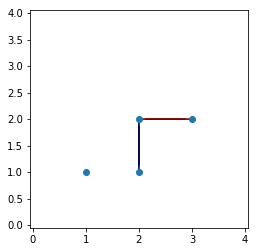

In [75]:
newg.add_new_spin(10)
newg.add_new_spin(11)
newg.add_interaction(10,11)
newg.add_new_spin(5)
newg.add_new_spin(6)
newg.add_interaction(10,6)

#newg.add_new_spin(11)
#newg.add_new_spin(15)
#newg.add_new_spin(7)

fig, ax = newg.plot()
#ax.quiver([[0,1,2], [1,1,1]],[1,1,1],[0,0,0,0,0,0])

0.00 1.00 0.00 -0.02 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 
-0.02 0.00 0.00 0.00 -0.06 0.00 1.00 0.00 0.00 
0.00 0.00 0.00 -0.06 0.00 -0.11 0.00 0.00 0.00 
0.00 0.00 1.00 0.00 -0.11 0.00 0.00 0.00 1.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.15 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.15 0.00 0.19 
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.19 0.00 


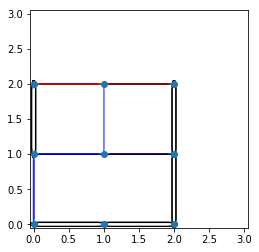

In [76]:
Hint = random.randn(4,4)
Hint = (Hint +Hint.transpose())*.2/2.0
for i in range(Hint.shape[0]):
    Hint[i,i] = 0.0
newg = game(Hint, Memb = 9)

newg.add_new_spin(4)
newg.add_new_spin(5)
newg.add_new_spin(7)
newg.add_new_spin(3)

# interaction spins 0,1
newg.add_interaction(4,5)


# interaction spins 0,2 and 0,3
newg.add_interaction(4,7)
newg.add_interaction(4,3)

# interaction spins 1,2
newg.copy_spin(5,2)
newg.copy_spin(2,1)
newg.copy_spin(1,0)
newg.add_interaction(0,3)
# and 1,3
newg.copy_spin(5,8)
newg.add_interaction(8,7)
# and 2,3
newg.copy_spin(3,6)
newg.add_interaction(6,7)

newg.print()
fig, ax = newg.plot()

In [96]:
Hint = random.randn(4,4)
Hint = (Hint +Hint.transpose())*.2/2.0
for i in range(Hint.shape[0]):
    Hint[i,i] = 0.0
newg = game(Hint, Memb = 9)

state, score, finished = newg.step(np.array([0, 4, 0]))
state, score, finished = newg.step(np.array([0, 5, 0]))
state, score, finished = newg.step(np.array([2, 4, 5]))


In [97]:
score

-0.35000000000000003

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f47cf8a0d50>)

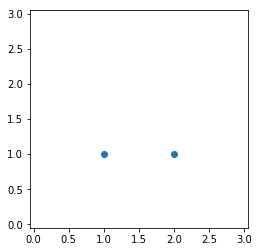

In [91]:
newg.plot()

In [ ]:
newg.add_new_spin(5)
newg.add_new_spin(7)
newg.add_new_spin(3)

# interaction spins 0,1
newg.add_interaction(4,5)


# interaction spins 0,2 and 0,3
newg.add_interaction(4,7)
newg.add_interaction(4,3)

# interaction spins 1,2
newg.copy_spin(5,2)
newg.copy_spin(2,1)
newg.copy_spin(1,0)
newg.add_interaction(0,3)
# and 1,3
newg.copy_spin(5,8)
newg.add_interaction(8,7)
# and 2,3
newg.copy_spin(3,6)
newg.add_interaction(6,7)

newg.print()
fig, ax = newg.plot()

In [231]:
from scipy.linalg import eigvals, eig

In [225]:
eHemb = np.abs(eigvals(newg.Hemb))
eHemb.sort()
eHemb-eHemb.min()

array([0.00000000e+00, 6.90508718e-02, 6.90508718e-02, 9.99924099e+01,
       9.99924099e+01, 1.00007783e+02, 1.00007783e+02, 1.73205091e+02,
       1.73205091e+02])

In [226]:
eH = np.abs(eigvals(newg.H))
eH.sort()
eH-eH.min()

array([0.        , 0.00815394, 0.14493225, 0.15308619])

## Brute force to find the interactions - Diagonalizing

In [314]:
Hint = random.randn(4,4)
Hint = (Hint +Hint.transpose())*.2/2.0
for i in range(Hint.shape[0]):
    Hint[i,i] = 0.0
    
def create_newmat(cf):
    newg = game(Hint, Memb = 9)

    newg.add_new_spin(4)
    newg.add_new_spin(5)
    newg.add_new_spin(7)
    newg.add_new_spin(3)

    # interaction spins 0,1
    newg.add_interaction(4,5, jint = cf[0])


    # interaction spins 0,2 and 0,3
    newg.add_interaction(4,7, jint = cf[1])
    newg.add_interaction(4,3, jint = cf[2])

    # interaction spins 1,2
    newg.copy_spin(5,2,fer_int =  cf[6])
    newg.copy_spin(2,1,fer_int = cf[7])
    newg.copy_spin(1,0,fer_int = cf[8])
    newg.add_interaction(0,3, jint = cf[3])
    # and 1,3
    newg.copy_spin(5,8,fer_int = cf[9])
    newg.add_interaction(8,7, jint = cf[4])
    # and 2,3
    newg.copy_spin(3,6,fer_int = cf[10])
    newg.add_interaction(6,7, jint = cf[5])
    return newg
def chi2_phi0(cf):
    newg = create_newmat(cf)
    hemb0 = eig(newg.Hemb)[1][0]
    eH0 =  eig(newg.H)[1][0]
    hemb0 = hemb0[np.array([4,5,7,3])]
    return np.sum((hemb0-eH0)**2)

def chi2_E0(cf):
    newg = create_newmat(cf)
    hemb0 = np.abs(eig(newg.Hemb)[0])
    eH0 = np.abs( eig(newg.H)[0])
    hemb0 = hemb0[:len(eH0)]
    hemb0.sort()
    eH0.sort()
    return np.sum((hemb0-eH0)**2)

In [315]:
cf0 = np.random.randn(11)
chi2_phi0(cf0), chi2_E0(cf0)

(2.09295444404802, 4.941470638973257)

In [316]:
from scipy.optimize import minimize

In [317]:
minx = minimize(chi2_phi0, np.array(cf0) , method = 'Nelder-Mead')
minx.x

array([ 1.71662480e-02, -9.47337971e-01, -9.63731012e-02,  1.88753456e-01,
        7.58703251e-02, -1.12121072e+00, -1.65789477e-03,  4.27411750e-01,
       -6.51753620e-01, -1.84378627e+00,  6.61197771e-02])

In [318]:
newg = create_newmat(minx.x)
hemb0 = eig(newg.Hemb)[1][0]
eH0 =  eig(newg.H)[1][0]
hemb0 = hemb0[np.array([4,5,7,3])]
print(eH0, hemb0)

[-0.94319685  0.15557765  0.29277786 -0.02136376] [-0.40962134  0.23377262  0.00095984 -0.23377262]


In [319]:
minx = minimize(chi2_E0, np.array(cf0) , method = 'Nelder-Mead')
minx.x

array([ 0.0174872 ,  0.0800361 , -0.15917211,  0.33714476,  0.16374086,
       -0.2880308 , -0.00075733,  0.16823028, -0.09861873, -0.29782544,
        0.1137321 ])

[0.01174857 0.07742759 0.16189732 0.22757634] [1.57874265e-17 1.58550866e-01 1.58550866e-01 2.21076481e-01
 2.21076481e-01 3.56728556e-01 3.56728556e-01 4.40319129e-01
 4.40319129e-01]


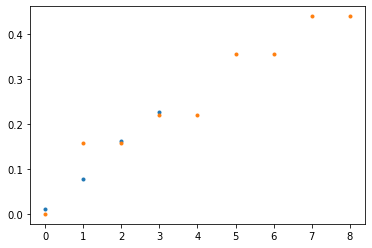

In [320]:
newg = create_newmat(minx.x)
hemb0 = np.abs(eig(newg.Hemb)[0])
eH0 = np.abs( eig(newg.H)[0])
hemb0.sort()
eH0.sort()
#hemb0 = hemb0[:len(eH0)]
print(eH0, hemb0)
plt.plot(eH0,'.')
plt.plot(hemb0,'.')

In [ ]:
#1406.2741
def findMinorEmbedding(game0, nmax = 1000):
    stage = 1
    suma = 0
    maxa = 0
    for it in range(nmax):
        
        if stage>2:
            break
        if sumn==suma:
            break
        if maxn==maxa:
            break
    
def shuffle_vertex(game0):
    pass
    return game0